In [11]:
import json

# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# https://stackoverflow.com/a/37704379
def nested_get(dic, keys):    
    for key in keys:
        dic = dic[key]
    return dic


def read_data(fp):
    data = []
    with open(fp) as f:
        for line in f:
            data.append(json.loads(line))
    
    return data


# Returns just the object fields we care about
def wrangle(res):
    props = {
        "query":            "config.query",
        "faster_copy":      "extra.faster_copy",
        "num_events":       "perf.numEvents",
        "num_results":      "perf.numResults",
        "events_per_sec":   "perf.eventsPerSec",
        "results_per_sec":  "perf.resultsPerSec",
        "runtime_sec":      "perf.runtimeSec",
        "coder":            "config.coderStrategy",
        "avg_auction_size": "config.avgAuctionByteSize",
        "avg_bid_size":     "config.avgBidByteSize",
        "avg_person_size":  "config.avgPersonByteSize",
        "parallelism": "extra.parallelism",
    }
    ret = {name: nested_get(res["Result"], keys.split(".")) for name, keys in props.items()}
    return ret

# Battery 03

This battery of tests varies over: query, coder, faster copy. Each run is repeated 10 times.
The parallalism is 2

In [2]:
def bat3_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["query", "coder", "faster_copy"]).sort_index()

    return df

## Loading the data

We load the data from the dump from the go program

In [3]:
bat3_all = read_data("../results/battery03/wow.json")
bat3_good = [wrangle(r) for r in bat3_all if r["Status"] == "OK"]
df =  bat3_convert_to_df(bat3_good)

## Question 1: How does `faster_copy` affect the different queries for normal queries

In [4]:
bf = df.xs(True, level=2) / df.xs(False, level=2)
bf = bf["events_per_sec"]

In [20]:
gg = bf.groupby(["query", "coder"]).agg(["mean", "std"])

In [21]:
jep = gg.unstack()["mean"].sort_values("HAND") - 1

In [22]:
jep

coder,AVRO,HAND,JAVA
query,,,
HIGHEST_BID,-0.006906,-0.024286,0.018924
USER_SESSIONS,0.016375,0.014112,NaN
BOUNDED_SIDE_INPUT_JOIN,0.024461,0.019769,NaN
AVERAGE_SELLING_PRICE_BY_SELLER,0.111259,0.081415,NaN
WINNING_BIDS,0.118262,0.096236,NaN
AVERAGE_PRICE_FOR_CATEGORY,0.109512,0.105380,NaN
SESSION_SIDE_INPUT_JOIN,0.158041,0.155035,NaN
HOT_ITEMS,0.287695,0.223407,NaN
PROCESSING_TIME_WINDOWS,0.352162,0.279736,NaN


<AxesSubplot:ylabel='query'>

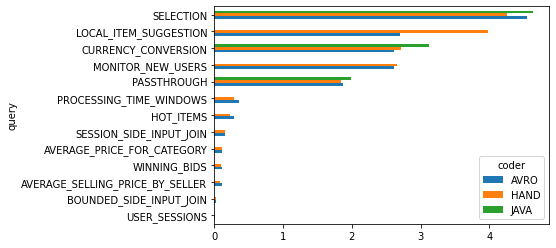

In [12]:
jep[(jep.isna() | (jep > 0)).all(axis=1)].plot(kind="barh")

Apparently the change is minimal between runners. The java serialiser only works
for certain queries. An outlier here is the `LOCAL_ITEM_SUGGESTION` query
where the `HAND` encoder perform a lot better.

One guess is that the queries which output a lot of records in the results would
be hit the hardest. We test this out.

In [9]:
results = df["num_results"].groupby("query").mean()

<AxesSubplot:ylabel='query'>

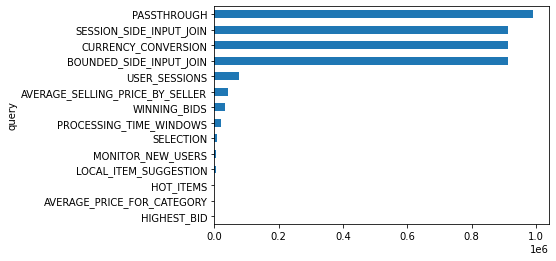

In [17]:
results.sort_values().plot(kind="barh")

Based on these results, this doesn't seem to be the case. It might be number of operators?

The `HIGHEST_BID` takes a lot of time to run and stalles, so it has been excluded from later benchmarks.

Since we have seen that the coders doesn't matter, let's look at just the hand coded results.

## Battery04: Does paralleism affect the speedup?

This battery tests if the number of parallel operators change how affected the benchmark is.
If there is no interplay here, there effect should simply be multiplied by the number of
paralllelism.

## Battery05: Does record size matter?

Change the size of the events to see if it has any effect. The idea is that
since the flink runner needs to marshal and unmarshal more.